In [1]:
## Perfoamnce with CFG graphs 

## Imports

In [2]:
import ast
import networkx as nx
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder
from utils import (
    read_code,
    generate_graph_from_ast,
    get_node_features,
    adjacency_matrix_to_edge_index,
    calculate_vcs2,
    calculate_similarity1,
    get_tokens,
    NormalizeNames,
    get_normalized_ast,
    ast_structure,
    calculate_similarity2,
    get_completion,
    calculate_similarity,
    calculate_vcs,
    extract_graph_from_pyg_data,
    load_original_code,
    get_code_from_graph,
)
import torch.nn.functional as F
import openai
import os
import pandas as pd
import time
import copy
import sklearn
import scipy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import subprocess
import json
import difflib
import tokenize
from io import BytesIO
import torch.nn as nn
import torch.optim as optim
import dgl.nn.pytorch as dglnn
import subprocess
import json

In [3]:
folder_name = "results_cfg_nov16"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

### Routines

In [4]:
def compare_asts(tree1, tree2):
    """
    Compare two ASTs and return a similarity measure.
    """
    nodes1 = list(ast.walk(tree1))
    nodes2 = list(ast.walk(tree2))

    common_nodes = len([node for node in nodes1 if any(isinstance(node, type(other)) for other in nodes2)])

    return common_nodes / max(len(nodes1), len(nodes2))

def calc_diff(code1, code2):
    try:
        tree1 = ast.parse(code1)
        tree2 = ast.parse(code2)
        return compare_asts(tree1, tree2)
    except SyntaxError:
        print("Syntax error encountered while calculating AST difference.")
        return float('inf')  # Return a large value to indicate a "large difference" due to the syntax error.
        

In [6]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 13
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['font.family'] = 'DejaVu Sans'

### ChatGPT key

### You need to add your API key here:

In [7]:

openai.api_key = "...." # 


### 1. CEW distribution 

In [38]:
# import os
# import subprocess
# import json
# import matplotlib.pyplot as plt
# from prettytable import PrettyTable

# def run_bandit(filename):
#     command = f"bandit -f json {filename}"
#     result = subprocess.run(command, shell=True, capture_output=True, text=True)
#     return result.stdout

# # Paths to the directories containing the .py files
# directories = ["others_pears22_1"]

# file_names = []
# for directory in directories:
#     file_names.extend([os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.py')])

# results_table = PrettyTable(["File", "Discovered CWEs", "Total CWEs"])

# total_cwes = []  # To store the total number of CWEs for each code
# all_cwe_ids = []  # To store all identified CWE IDs





# # file_names=file_names[0:15]






# for filename in file_names:
#     print(f"Analyzing {filename}")
#     analysis_result = run_bandit(filename)
#     result_json = json.loads(analysis_result)

#     unique_cwe_ids = set()

#     if "results" in result_json and result_json["results"]:
#         for issue in result_json["results"]:
#             cwe_id = str(issue["issue_cwe"]["id"])
#             unique_cwe_ids.add(cwe_id)
#             all_cwe_ids.append(cwe_id)

#         unique_cwes_str = ", ".join(unique_cwe_ids)
#         total_unique_cwes = len(unique_cwe_ids)
#         results_table.add_row([filename, unique_cwes_str, total_unique_cwes])
#         total_cwes.append(total_unique_cwes)
#     else:
#         results_table.add_row([filename, "No issues found", 0])
#         total_cwes.append(0)

#     print("=" * 40)  # Print a separator

# # Print the original table
# print("Original Table:")
# print(results_table)

In [8]:
# # Visualization: Bar chart of total CWEs per file
# # Plotting
# plt.figure(figsize=(10, 6))
# plt.plot(range(len(file_names)), total_cwes, marker='o', linestyle='None')
# plt.xlabel('Code File Index')
# plt.ylabel('Total CWEs')
# plt.title('Total CWEs per Code Base')
# plt.tight_layout()
# plt.grid(True)
# base_filename="results_cfg_nov16/cwe_per_codebase_cross"
# plt.savefig(f"{base_filename}.png", dpi=150, bbox_inches='tight')
# plt.savefig(f"{base_filename}.pdf", dpi=150, bbox_inches='tight')
# plt.show()

# # Analysis of the most common CWEs
# cwe_counts = dict()
# for cwe in all_cwe_ids:
#     if cwe not in cwe_counts:
#         cwe_counts[cwe] = 1
#     else:
#         cwe_counts[cwe] += 1

# # Displaying most common CWEs
# most_common_cwes = sorted(cwe_counts.items(), key=lambda x: x[1], reverse=True)

# print("\nMost Common CWEs:")
# for cwe, count in most_common_cwes:
#     print(f"{cwe}: {count} occurrences")


# # Visualization: Histogram of CWE occurrences
# # plt.figure(figsize=(10, 6))
# plt.bar(cwe_counts.keys(), cwe_counts.values(), color='red')
# plt.xlabel('CWE ID')
# plt.ylabel('Occurrences')
# plt.xticks(rotation=90, fontsize=8)
# plt.title('Occurrences of Each CWE')
# plt.tight_layout()
# plt.grid(True)
# base_filename="results_cfg_nov16/codebase_CWE_hist_cross"
# plt.savefig(f"{base_filename}.png", dpi=150, bbox_inches='tight')
# plt.savefig(f"{base_filename}.pdf", dpi=150, bbox_inches='tight')
# plt.show()

# # Analysis of the most common CWEs
# most_common_cwes = sorted(cwe_counts.items(), key=lambda x: x[1], reverse=True)

# print("\nMost Common CWEs:")
# for cwe, count in most_common_cwes:
#     print(f"{cwe}: {count} occurrences")


In [9]:
# import os
# import ast
# import matplotlib.pyplot as plt
# import matplotlib.ticker as ticker

# line_counts = []
# function_counts = []

# def count_functions(node):
#     """Count function definitions in an AST node."""
#     return sum(1 for n in ast.walk(node) if isinstance(n, ast.FunctionDef))

# for filename in file_names:
#     print(f"Analyzing {filename}")

#     # Counting lines
#     with open(filename, 'r') as f:
#         lines = f.readlines()
#         line_count = len(lines)
#         line_counts.append(line_count)

#     # Counting functions
#     try:
#         with open(filename, 'r') as f:
#             content = f.read()
#             tree = ast.parse(content)
#             function_count = count_functions(tree)
#             function_counts.append(function_count)
#     except SyntaxError:
#         print(f"Failed to parse {filename} due to syntax error.")
#         continue

#     print(f"{filename}: {line_count} lines, {function_count} functions")
#     print("=" * 40)  # Print a separator


#     # Counting functions
#     with open(filename, 'r') as f:
#         content = f.read()
#         tree = ast.parse(content)
#         function_count = count_functions(tree)
#         function_counts.append(function_count)

#     print(f"{filename}: {line_count} lines, {function_count} functions")
#     print("=" * 40)  # Print a separator




In [10]:
# # Histogram for number of lines
# # plt.figure(figsize=(10, 5))
# plt.hist(line_counts, bins='auto', color='blue', edgecolor='blue', alpha=0.7)
# plt.xlabel('Number of Lines')
# plt.ylabel('Number of Files')
# plt.title('Number of Lines Histogram')
# plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
# plt.tight_layout()
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# base_filename = "results_cfg_nov16/hist_no_of_lines_cross"
# plt.tight_layout()  # to ensure the labels do not get cut off during save
# plt.savefig(f"{base_filename}.png", dpi=150, bbox_inches='tight')
# plt.savefig(f"{base_filename}.pdf", dpi=150, bbox_inches='tight')
# plt.show()

# # Histogram for number of functions
# # plt.figure(figsize=(10, 5))
# plt.hist(function_counts, bins='auto', color='green', edgecolor='green', alpha=0.7)
# plt.xlabel('Number of Functions')
# plt.ylabel('Number of Files')
# plt.title('Number of Functions Histogram')
# plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
# plt.tight_layout()
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# base_filename = "results_cfg_nov16/hist_no_of_funs_cross"
# plt.tight_layout()  # to ensure the labels do not get cut off during save
# plt.savefig(f"{base_filename}.png", dpi=150, bbox_inches='tight')
# plt.savefig(f"{base_filename}.pdf", dpi=150, bbox_inches='tight')
# plt.show()

## 2. load training trainign data

In [11]:
import ast
import networkx as nx

def generate_cfg_from_code(file_path):
    with open(file_path, 'r') as f:
        code = f.read()

    # Parse the Python source code into an AST
    tree = ast.parse(code)

    # Start generating the CFG
    cfg = nx.DiGraph()
    build_cfg_from_ast(tree, cfg)

    return cfg

def build_cfg_from_ast(node, graph, prev_node=None):
    # Handle simple statements by just adding them as nodes in the graph
    if isinstance(node, ast.stmt):
        current_node = str(node.lineno)
        graph.add_node(current_node, ast_node=node)

        if prev_node is not None:
            graph.add_edge(prev_node, current_node)

        # Special handling for control structures
        if isinstance(node, ast.If):
            build_cfg_from_ast(node.body, graph, current_node)
            build_cfg_from_ast(node.orelse, graph, current_node)
            return
        elif isinstance(node, (ast.For, ast.While)):
            build_cfg_from_ast(node.body, graph, current_node)
            return

        prev_node = current_node

    # If it's not a simple statement, it's a list of statements (like body of If, For, etc.)
    elif isinstance(node, list):
        for child in node:
            prev_node = build_cfg_from_ast(child, graph, prev_node)

    return prev_node



In [12]:
def get_node_features(graph, node):
    """
    Extract binary features from CFG nodes.

    Parameters:
        graph (DiGraph): The graph containing the node.
        node: The node from which to extract features.

    Returns:
        list: List of binary features extracted from the node.
    """
    features = []

    # Get node attributes from the graph
    node_data = graph.nodes[node]

    # Extract binary features from node attributes. 
    # Assumes that these attributes exist in your CFG, you might need to adjust
    has_function_def = node_data.get('contains_function', False)
    features.append(int(has_function_def))

    has_loop = node_data.get('contains_loop', False)
    features.append(int(has_loop))

    has_conditional = node_data.get('contains_if', False)
    features.append(int(has_conditional))

    has_comment = node_data.get('contains_comment', False)  # This might be tricky for CFGs, might not be applicable
    features.append(int(has_comment))

    # Add more binary features as needed...

    return features


In [13]:
import os
import networkx as nx  # Assumed networkx is used for graph representation
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data

def adjacency_matrix_to_edge_index(adj_matrix):
    # Convert an adjacency matrix to an edge index representation
    rows, cols = np.where(adj_matrix == 1)
    return torch.tensor([rows, cols], dtype=torch.long)

# List all files in the folder "others_pears22_1" with the .py extension
folder_path = "others_pears22_1"
file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.py')]

# Hypothetical function to generate CFG from code
def generate_cfg_from_code(file_path):
    # This function should read the file and generate a CFG. 
    # We'll assume the CFG is represented using a networkx graph.
    # Placeholder logic; this should be replaced with actual CFG generation code
    cfg = nx.DiGraph() 
    with open(file_path, 'r') as file:
        content = file.read()
        # Here, you'd typically analyze 'content' and add nodes/edges to 'cfg' 
        # For this example, let's assume one node per line (this is very naive and just for demonstration)
        for i, line in enumerate(content.split('\n')):
            cfg.add_node(i, line=line.strip())
            if i > 0:
                cfg.add_edge(i-1, i)
    return cfg if cfg.nodes() else None

# Load training code bases and convert to training graphs
training_data = []

for file_path in file_paths:
    cfg = generate_cfg_from_code(file_path)
    if cfg is None:
        print(f"Empty CFG for file: {file_path}")
        continue
    node_features = [get_node_features(cfg, node) for node in cfg.nodes()]

    training_data.append({'graph': cfg, 'features': node_features})

# Create a label encoder
label_encoder = LabelEncoder()

# Create a list to store PyG Data objects
pyg_data_list = []

# Process each graph in the training data
for graph_data in training_data:
    graph = graph_data['graph']
    adj_matrix = nx.adjacency_matrix(graph).toarray()

    # Convert node features to a proper shape
    node_features = np.array(graph_data['features'])
    num_nodes = len(node_features)
    node_features = node_features.reshape(num_nodes, -1)  # Reshape to a 2D array

    # Flatten and encode labels
    x_list = [item for sublist in node_features for item in sublist]
    encoded_labels = label_encoder.fit_transform(x_list)
    encoded_labels = torch.tensor(encoded_labels, dtype=torch.float32)  # Use float32 for node features
    encoded_labels = encoded_labels.unsqueeze(1)

    # Create a PyG Data object
    edge_index = adjacency_matrix_to_edge_index(adj_matrix)
    pyg_data = Data(x=encoded_labels, edge_index=edge_index)

    pyg_data_list.append(pyg_data)


/tmp/ipykernel_8148/686633326.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.tensor([rows, cols], dtype=torch.long)


In [14]:
# print(pyg_data_list_test)

## 3. model training

In [15]:
# print(pyg_data_list)

In [16]:

edges = pyg_data_list[0].edge_index
# # Generate a code representation from the edge list
code_lines = []
for edge in edges:
    code_line = f"add_edge({edge[0]}, {edge[1]})"
    code_lines.append(code_line)
code_representation = "\n".join(code_lines)
# # Now, pass the code representation to the calculate_vcs function
# cwe_count = calculate_vcs(code_representation)

In [17]:
# Define the VCS function
def VCS(generated_graph):
    adjacency_matrix = (generated_graph > 0).int()
    # Convert adjacency matrix to an edge list
    edges = torch.nonzero(adjacency_matrix, as_tuple=False)
    # Generate a code representation from the edge list
    code_lines = []
    for edge in edges:
        code_line = f"add_edge({edge[0]}, {edge[1]})"
        code_lines.append(code_line)
    code_representation = "\n".join(code_lines)
    # Now, pass the code representation to the calculate_vcs function
    cwe_count = calculate_vcs(code_representation)
    return cwe_count

import subprocess
import json
from prettytable import PrettyTable
import matplotlib.pyplot as plt

def run_bandit(filename):
    command = f"bandit -f json {filename}"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    return result.stdout


### Here is the contrastive training 

In [18]:
from torch_geometric.data import Data

def create_pyg_data(x, edge_index, edge_attr=None):
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)


In [19]:
def estimate_updated_code_cfg(original_code, original_graph, updated_graph):
    # 1. Handle Deleted Nodes:
    deleted_nodes = [node for node in original_graph.nodes if node not in updated_graph.nodes]
    
    # 2. Handle New Nodes:
    new_nodes = [node for node in updated_graph.nodes if node not in original_graph.nodes]
    
    # Generate code snippets for new nodes
    new_code_snippets = []
    for node in new_nodes:
        # In a CFG, this could represent adding new blocks of code.
        # For simplicity, we'll treat each node as a block of code.
        new_code_snippet = f"# New code block for {node}\n"
        new_code_snippets.append(new_code_snippet)
    
    # 3. Flexible Placeholder System:
    updated_code_lines = original_code.splitlines()
    for idx, line in enumerate(updated_code_lines):
        if line.strip() == "# Placeholder for new nodes":
            updated_code_lines[idx:idx+1] = new_code_snippets
    
    # 4. Remove or Comment out Deleted Nodes:
    for node in deleted_nodes:
        for idx, line in enumerate(updated_code_lines):
            if line.strip() == f"# Code block for {node}":
                updated_code_lines[idx] = f"# Deleted code block for {node}"
                break 
    # 5. Adjust Edges:
    # You might want to consider how new edges (or removed edges) in the updated_graph 
    # could affect the structure of the code. This could mean adding/removing if-statements, 
    # loops, or other control flow constructs.
    # This is a non-trivial step and would require more specifics about how you represent
    # and detect such changes in control flow.   
    # 6. Enhanced Formatting:
    updated_code = '\n'.join(updated_code_lines)   
    return updated_code


In [20]:
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric.nn as pyg_nn
from torch.nn import BCEWithLogitsLoss
import subprocess

# Define the dimensions for the Generator and Discriminator
in_feats = 1
hidden_feats = 128  # Increased hidden layer size
out_feats = 1  # Output dimension for Generator
disc_hidden_feats = 64  # Increased hidden layer size for Discriminator

class Generator(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(Generator, self).__init__()
        self.conv1 = pyg_nn.GraphConv(in_feats, hidden_feats)
        self.conv2 = pyg_nn.GraphConv(hidden_feats, out_feats)
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        return x, edge_index

class Discriminator(nn.Module):
    def __init__(self, in_feats, hidden_feats):
        super(Discriminator, self).__init__()
        self.conv1 = pyg_nn.GraphConv(in_feats, hidden_feats)
        self.conv2 = pyg_nn.GraphConv(hidden_feats, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        x = self.sigmoid(x)
        return x


# def compute_contrastive_loss(updated_x, x, g_before, g_after, ci, ci_hat, temperature=0.1):
#     try:
#         # Convert graph to string format if it is an instance of nx.Graph
#         if isinstance(g_before, nx.Graph):
#             str_g_before = "\n".join(map(str, nx.to_edgelist(g_before)))
#         else:
#             str_g_before = str(g_before)

#         if isinstance(g_after, nx.Graph):
#             str_g_after = "\n".join(map(str, nx.to_edgelist(g_after)))
#         else:
#             str_g_after = str(g_after)

#         # Compute similarity
#         similarity_before_after = torch.tensor(calculate_similarity(str_g_before, str_g_after), dtype=torch.float32)

#         # Calculate the security loss for both g_before and g_after
#         security_loss_before = calculate_vcs(g_before)
#         security_loss_after = calculate_vcs(ci_hat)

#         # Calculate the difference in security loss
#         security_loss_diff = security_loss_after - security_loss_before  # Encouraging lesser CWEs in ci_hat

#         # Compute feature difference loss
#         feature_diff_loss = torch.mean(torch.abs(updated_x - x))

#         # It's important to make sure that the overall divisor in the loss calculation does not become non-positive.
#         divisor = torch.exp(similarity_before_after / temperature) + feature_diff_loss + max(0, security_loss_diff)

#         # Compute contrastive loss
#         contrastive_loss = -torch.log(torch.exp(similarity_before_after / temperature) / divisor)
#         # print("Security Loss Diff:", security_loss_diff, "Feature Diff Loss:", feature_diff_loss)

#         return contrastive_loss, security_loss_diff, feature_diff_loss

#     except Exception as e:
#         print(f"Error in compute_contrastive_loss: {e}")
#         return torch.tensor(0.0), 0, 0
        
# # Define the rest of your code...

# # Initialize hyperparameters
# lr = 0.001
# num_epochs = 7
# temperature = 1.5
# discriminator_epochs = 5

# # Initialize the Generator and Discriminator
# generator = Generator(in_feats, hidden_feats, out_feats)
# discriminator = Discriminator(in_feats, disc_hidden_feats)

# # Initialize models, optimizers, and loss function
# optimizer_g = optim.Adam(generator.parameters(), lr=lr)
# optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)
# bce_loss = BCEWithLogitsLoss()

# security_loss_diffs_per_epoch=[]
# feature_diff_losses_per_epoch=[]
# # Training Loop
# generator_losses_per_sample = []
# discriminator_losses_per_sample = []
# generator_losses_per_epoch = []
# discriminator_losses_per_epoch = []
# security_loss_diffs_per_epoch = []
# feature_diff_losses_per_epoch = []

# num_graphs_trained = 0
# for epoch in range(num_epochs):
#     generator_loss_epoch = 0
#     discriminator_loss_epoch = 0
#     num_samples = 0
#     security_loss_diff_epoch = 0  # Initialize here
#     feature_diff_loss_epoch = 0  # Initialize here
    

#     for i, pyg_data in enumerate(pyg_data_list[0:500]):
#         x, edge_index, edge_attr = pyg_data.x, pyg_data.edge_index, pyg_data.edge_attr

#         # Train Discriminator
#         for _ in range(discriminator_epochs):
#             optimizer_d.zero_grad()
#             logits_real = discriminator(x, edge_index)
#             updated_x, _ = generator(x, edge_index)
#             logits_fake = discriminator(updated_x.detach(), edge_index)
#             loss_d = bce_loss(logits_real, torch.ones_like(logits_real)) + bce_loss(logits_fake, torch.zeros_like(logits_fake))
#             loss_d.backward()
#             optimizer_d.step()
#         discriminator_losses_per_sample.append(loss_d.item())

#         # Train Generator
#         optimizer_g.zero_grad()
#         updated_x, new_edge_index = generator(x, edge_index)

#         # Extract Graphs
#         g_before = extract_graph_from_pyg_data(pyg_data)

#         # Save g_before to a GraphML file
#         before_graph_filename = f'graph_before_{i}.graphml'
#         nx.write_graphml(g_before, before_graph_filename)

#         updated_pyg_data = create_pyg_data(updated_x, new_edge_index)
#         g_after = extract_graph_from_pyg_data(updated_pyg_data)

#         # Save g_after to a GraphML file
#         after_graph_filename = f'graph_after_{i}.graphml'
#         nx.write_graphml(g_after, after_graph_filename)

#         # Compute contrastive loss
#         file_path = file_paths[i]
#         ci = load_original_code(file_path)
#         ci_hat = estimate_updated_code_cfg(ci, g_before, g_after)
#         loss_c, security_loss_diff, feature_diff_loss = compute_contrastive_loss(updated_x, x, before_graph_filename, after_graph_filename, ci, ci_hat, temperature)
#         loss_g = bce_loss(discriminator(updated_x, edge_index), torch.ones_like(logits_real)) + loss_c
#         loss_g.backward()
#         optimizer_g.step()
#         num_graphs_trained += 1
#         generator_losses_per_sample.append(loss_g.item())

#         generator_loss_epoch += loss_g.item()
#         discriminator_loss_epoch += loss_d.item()
#         num_samples += 1

#         # Accumulate security loss diff and feature diff loss
#         security_loss_diff_epoch += security_loss_diff
#         feature_diff_loss_epoch += feature_diff_loss

#     print("epoch", epoch, "security_loss_diff", security_loss_diff, "feature_diff_loss", feature_diff_loss)  

#     generator_losses_per_epoch.append(generator_loss_epoch / num_samples)
#     discriminator_losses_per_epoch.append(discriminator_loss_epoch / num_samples)

#     # Store accumulated security loss diff and feature diff loss for this epoch
#     security_loss_diffs_per_epoch.append(security_loss_diff_epoch / num_samples)
#     feature_diff_losses_per_epoch.append(feature_diff_loss_epoch / num_samples)


In [21]:
# print("Training finished!")
# torch.save(generator.state_dict(), "trained_generator_cfg.pt")
# torch.save(discriminator.state_dict(), "trained_discriminator_cfg.pt")

In [22]:
# print(generator_losses_per_epoch)
# print(discriminator_losses_per_epoch)

In [23]:
# import matplotlib.pyplot as plt

# # Assuming you have populated the lists security_loss_diffs_per_epoch and feature_diff_losses_per_epoch

# # Number of epochs
# num_epochs = len(security_loss_diffs_per_epoch)

# # Create lists for epoch numbers
# epochs = list(range(1, num_epochs + 1))

# # Plot security loss diff
# plt.figure(figsize=(10, 5))
# plt.plot(epochs, security_loss_diffs_per_epoch, label='Security Loss Difference')
# plt.xlabel('Epoch')
# plt.ylabel('Security Loss Difference')
# plt.title('Security Loss Difference vs. Epoch')
# plt.legend()
# plt.grid(True)
# plt.show()


In [24]:
# # Plot feature diff loss
# plt.figure(figsize=(10, 5))
# feature_diff_losses_np = [loss.item() for loss in feature_diff_losses_per_epoch]
# plt.plot(epochs, feature_diff_losses_np, label='Feature Diff Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Feature Diff Loss')
# plt.title('Feature Diff Loss vs. Epoch')
# plt.legend()
# plt.grid(True)
# plt.show()


## 4. Test and performance analysis

In [25]:
import os
import networkx as nx  # Assumed networkx is used for graph representation
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data

def adjacency_matrix_to_edge_index(adj_matrix):
    # Convert an adjacency matrix to an edge index representation
    rows, cols = np.where(adj_matrix == 1)
    return torch.tensor([rows, cols], dtype=torch.long)

# List all files in the folder "others_pears22_1" with the .py extension
folder_path = "file_names_top100"
file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.py')]

# Hypothetical function to generate CFG from code
def generate_cfg_from_code(file_path):
    # This function should read the file and generate a CFG. 
    # We'll assume the CFG is represented using a networkx graph.
    # Placeholder logic; this should be replaced with actual CFG generation code
    cfg = nx.DiGraph() 
    with open(file_path, 'r') as file:
        content = file.read()
        # Here, you'd typically analyze 'content' and add nodes/edges to 'cfg' 
        # For this example, let's assume one node per line (this is very naive and just for demonstration)
        for i, line in enumerate(content.split('\n')):
            cfg.add_node(i, line=line.strip())
            if i > 0:
                cfg.add_edge(i-1, i)
    return cfg if cfg.nodes() else None

# Load training code bases and convert to training graphs
training_data = []

for file_path in file_paths:
    cfg = generate_cfg_from_code(file_path)
    if cfg is None:
        print(f"Empty CFG for file: {file_path}")
        continue
    node_features = [get_node_features(cfg, node) for node in cfg.nodes()]

    training_data.append({'graph': cfg, 'features': node_features})

# Create a label encoder
label_encoder = LabelEncoder()

# Create a list to store PyG Data objects
pyg_data_list_test = []

# Process each graph in the training data
for graph_data in training_data:
    graph = graph_data['graph']
    adj_matrix = nx.adjacency_matrix(graph).toarray()

    # Convert node features to a proper shape
    node_features = np.array(graph_data['features'])
    num_nodes = len(node_features)
    node_features = node_features.reshape(num_nodes, -1)  # Reshape to a 2D array

    # Flatten and encode labels
    x_list = [item for sublist in node_features for item in sublist]
    encoded_labels = label_encoder.fit_transform(x_list)
    encoded_labels = torch.tensor(encoded_labels, dtype=torch.float32)  # Use float32 for node features
    encoded_labels = encoded_labels.unsqueeze(1)

    # Create a PyG Data object
    edge_index = adjacency_matrix_to_edge_index(adj_matrix)
    pyg_data_test = Data(x=encoded_labels, edge_index=edge_index)

    pyg_data_list_test.append(pyg_data_test)


In [26]:
iter_num=10

In [29]:
def estimate_updated_code(original_code, original_graph, updated_graph):
    # 1. Handle Deleted Nodes:
    deleted_nodes = [node for node in original_graph.nodes if node not in updated_graph.nodes]
    
    # 2. Handle New Nodes:
    new_nodes = [node for node in updated_graph.nodes if node not in original_graph.nodes]
    
    # Generate code snippets for new nodes
    new_code_snippets = []
    for node in new_nodes:
        # In a CFG, this could represent adding new blocks of code.
        # For simplicity, we'll treat each node as a block of code.
        new_code_snippet = f"# New code block for {node}\n"
        new_code_snippets.append(new_code_snippet)
    
    # 3. Flexible Placeholder System:
    updated_code_lines = original_code.splitlines()
    for idx, line in enumerate(updated_code_lines):
        if line.strip() == "# Placeholder for new nodes":
            updated_code_lines[idx:idx+1] = new_code_snippets
    
    # 4. Remove or Comment out Deleted Nodes:
    for node in deleted_nodes:
        for idx, line in enumerate(updated_code_lines):
            if line.strip() == f"# Code block for {node}":
                updated_code_lines[idx] = f"# Deleted code block for {node}"
                break 
    # 5. Adjust Edges:
    # You might want to consider how new edges (or removed edges) in the updated_graph 
    # could affect the structure of the code. This could mean adding/removing if-statements, 
    # loops, or other control flow constructs.
    # This is a non-trivial step and would require more specifics about how you represent
    # and detect such changes in control flow.   
    # 6. Enhanced Formatting:
    updated_code = '\n'.join(updated_code_lines)   
    return updated_code


In [30]:
def vet_code2(ci, pyg_data_test_i):
    g_before = extract_graph_from_pyg_data(pyg_data_test_i)
    k_bef, CWEs_bef = calculate_vcs2(ci)
#     cwe_list_bef.append(CWEs_bef)
    x, edge_index = pyg_data_test_i.x.to(device), pyg_data_test_i.edge_index.to(device)
    updated_x, new_edge_index = generator(x, edge_index)  # Adjusted by generator
    
    feature_loss = torch.mean(torch.abs(updated_x - x))
    
#     # Calculate the difference in edges between g_after and g_before
#     edge_diff = (new_edge_index.size(1) - edge_index.size(1))
    
#     # Combine feature and edge losses with a weight factor if needed
#     total_loss = feature_loss + edge_diff  # You can adjust the weights or add more complex logic if needed
    
    # Calculate the new graph representation using updated_x and new_edge_index
    g_after = extract_graph_from_pyg_data(Data(updated_x, new_edge_index))
    ci_hat = estimate_updated_code(ci, g_before, g_after)
  
    prompt_inv1 = """
    Estimate a detailed prompt that could be given to ChatGPT to generate the Python code:
    """
    p0 = prompt_inv1 + "[" + ci_hat + "]. Try to be as specific as possible. The prompt must assure that the code must be in Python, not any other language." 

    p_inext = get_completion(p0) + ". Do not put any explanatory text, marks, or comments. Only give the source code as a response."
    
    codei_vetted = get_completion(p_inext)

    pyg_data_test_i_hat = Data(updated_x, new_edge_index)

    return codei_vetted, feature_loss.item(), pyg_data_test_i_hat


In [41]:
# Create a dictionary to store the CWE counts for each file
cwe_counts = {}
folder_path = "file_names_top100"
all_files = [f for f in os.listdir(folder_path) if f.endswith('.py')]
all_files.sort()
top_20_files = all_files


In [40]:
# Display CWE counts for all files
print("CWE counts for all files:")
for filename, cwe_count in cwe_counts.items():
    print(f"File: {filename}, CWE count: {cwe_count}")

CWE counts for all files:


In [33]:
# # Display CWE counts for the selected top 20 files
# print("CWE counts for the selected top 20 files:")
# for filename in top_20_files:
#     print(f"File: {filename}, CWE count: {cwe_counts[filename]}")

In [34]:
selected_indices = [all_files.index(filename) for filename in top_20_files]
selected_pyg_data_test = [pyg_data_list_test[i] for i in selected_indices]
print(selected_indices)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [35]:
# selected_pyg_data_test = [pyg_data_list_test[i] for i in selected_indices]

# Here is the test loop to fix the codes

In [37]:
import os
import datetime
import torch
import shutil
import copy
import matplotlib.pyplot as plt
from openai.error import Timeout
from torch_geometric.data import Data

# Create the folder with the specified naming pattern
today = datetime.date.today()
output_folder = (
    f"test_vetted_codes_pers_cfg_na_FIXED_{today.month}_{today.day}_{today.year}"
)
os.makedirs(output_folder, exist_ok=True)

# Load the saved models
device = torch.device("cuda:0")


# Initialize the Generator and Discriminator
generator = Generator(in_feats, hidden_feats, out_feats).to(device)
discriminator = Discriminator(in_feats, disc_hidden_feats).to(device)

generator.load_state_dict(torch.load("trained_generator_cfg.pt", map_location=device))
discriminator.load_state_dict(
    torch.load("trained_discriminator_cfg.pt", map_location=device)
)

generator.eval()
discriminator.eval()

# Test setup
num_graphs_tested = 0

remaining_k_arr = [[] for _ in range(len(top_20_files))]
remaining_cwe_arr = [[] for _ in range(len(top_20_files))]
remaining_sim_arr = [[] for _ in range(len(top_20_files))]
remaining_ast_sim_arr=[[] for _ in range(len(top_20_files))]
CWE_org_arr=[[] for _ in range(len(top_20_files))]
k_org_arr=[[] for _ in range(len(top_20_files))]
req_iter_num_arr=[[] for _ in range(len(top_20_files))]
k_after_1_iter_arr=[[] for _ in range(len(top_20_files))]
sim_after_1_iter_arr=[[] for _ in range(len(top_20_files))]
sim_ast_after_1_iter_arr=[[] for _ in range(len(top_20_files))]

# Test the model
with torch.no_grad():
    for idx, filename in enumerate(top_20_files):
        try:
            file_path = os.path.join(folder_path, filename)
            shutil.copy(file_path, os.path.join(output_folder, filename))
            ci = load_original_code(file_path)
            ci_org = copy.deepcopy(ci)
            k_bef, CWEs_bef = calculate_vcs2(ci_org)
            CWE_org_arr[idx]=CWEs_bef
            k_org_arr[idx]=k_bef       

            loss2_bef = calculate_vcs(ci)
            print("k_bef", k_bef)

            pyg_data_test_i = selected_pyg_data_test[idx]

            for iteration in range(iter_num):
                ci, current_loss1, pyg_data_test_i_hat = vet_code2(ci, pyg_data_test_i)
                pyg_data_test_i=pyg_data_test_i_hat
               
                k, CWEs = calculate_vcs2(ci)
                print("iter", iteration, "k", k, ".... CWEs", CWEs)
                
                ast_sim = calc_diff(ci_org, ci)
                
                if iteration ==0:
                    k_after_1_iter_arr[idx]=k
                    sim_after_1_iter_arr[idx]=current_loss1
                    sim_ast_after_1_iter_arr[idx]=ast_sim

                if k==0:
                    
                    break
                     
                    
            vetted_filename = filename.replace(".py", "_vet.py")
            vetted_filepath = os.path.join(output_folder, vetted_filename)
            with open(vetted_filepath, "w") as vetted_file:
                vetted_file.write(ci)

            
            remaining_k_arr[idx]=k
            remaining_cwe_arr[idx]=CWEs
            remaining_sim_arr[idx] = current_loss1
            remaining_ast_sim_arr[idx]=ast_sim
            req_iter_num_arr[idx]=iteration
            
            
            num_graphs_tested += 1
            print(f"Graph {num_graphs_tested} Processed")

            # Print the file index
            print(f"File Index: {idx + 1}, Graph {num_graphs_tested} Processed")

        except SyntaxError as e:
            print(
                f"Encountered a syntax error for File {filename} - Skipping this file. Error details: {str(e)}"
            )
            continue
        except Timeout as e:
            print(
                f"API Timeout encountered for File {filename} - Skipping this file. Error details: {str(e)}"
            )
            continue
        except Exception as e:
            print(f"An error occurred in processing {filename}: {str(e)}")
            continue

# After the loop ends:
print(f"Tested a total of {num_graphs_tested} graphs.")


k_bef 3
iter 0 k 1 .... CWEs [259]
iter 1 k 1 .... CWEs [259]
iter 2 k 0 .... CWEs []
Syntax error encountered while calculating AST difference.
Graph 1 Processed
File Index: 1, Graph 1 Processed
k_bef 3
iter 0 k 3 .... CWEs [89, 259, 78]
iter 1 k 3 .... CWEs [89, 259, 78]
iter 2 k 3 .... CWEs [89, 259, 78]
iter 3 k 2 .... CWEs [259, 78]
iter 4 k 2 .... CWEs [259, 78]
iter 5 k 2 .... CWEs [259, 78]
iter 6 k 2 .... CWEs [259, 78]
iter 7 k 2 .... CWEs [259, 78]
iter 8 k 2 .... CWEs [259, 78]
iter 9 k 2 .... CWEs [259, 78]
Graph 2 Processed
File Index: 2, Graph 2 Processed
k_bef 4
iter 0 k 3 .... CWEs [259, 78, 327]
iter 1 k 3 .... CWEs [259, 78, 327]
iter 2 k 3 .... CWEs [259, 78, 327]
iter 3 k 0 .... CWEs []
Syntax error encountered while calculating AST difference.
Graph 3 Processed
File Index: 3, Graph 3 Processed
k_bef 4
iter 0 k 0 .... CWEs []
Syntax error encountered while calculating AST difference.
Graph 4 Processed
File Index: 4, Graph 4 Processed
k_bef 3
iter 0 k 3 .... CWEs [8

k_bef 2
iter 0 k 2 .... CWEs [259, 78]
iter 1 k 1 .... CWEs [259]
iter 2 k 1 .... CWEs [259]
iter 3 k 0 .... CWEs []
Syntax error encountered while calculating AST difference.
Graph 35 Processed
File Index: 35, Graph 35 Processed
k_bef 3
iter 0 k 0 .... CWEs []
Syntax error encountered while calculating AST difference.
Graph 36 Processed
File Index: 36, Graph 36 Processed
k_bef 2
iter 0 k 2 .... CWEs [259, 78]
iter 1 k 2 .... CWEs [259, 78]
iter 2 k 2 .... CWEs [259, 78]
iter 3 k 0 .... CWEs []
Syntax error encountered while calculating AST difference.
Graph 37 Processed
File Index: 37, Graph 37 Processed
k_bef 3
iter 0 k 0 .... CWEs []
Syntax error encountered while calculating AST difference.
Graph 38 Processed
File Index: 38, Graph 38 Processed
k_bef 3
iter 0 k 1 .... CWEs [259]
iter 1 k 1 .... CWEs [259]
iter 2 k 0 .... CWEs []
Syntax error encountered while calculating AST difference.
Graph 39 Processed
File Index: 39, Graph 39 Processed
k_bef 3
iter 0 k 1 .... CWEs [259]
iter 1 k

iter 3 k 1 .... CWEs [259]
iter 4 k 0 .... CWEs []
Syntax error encountered while calculating AST difference.
Graph 77 Processed
File Index: 77, Graph 77 Processed
k_bef 3
iter 0 k 1 .... CWEs [259]
iter 1 k 0 .... CWEs []
Syntax error encountered while calculating AST difference.
Graph 78 Processed
File Index: 78, Graph 78 Processed
k_bef 3
iter 0 k 2 .... CWEs [259, 78]
iter 1 k 0 .... CWEs []
Syntax error encountered while calculating AST difference.
Graph 79 Processed
File Index: 79, Graph 79 Processed
k_bef 3
iter 0 k 1 .... CWEs [259]
iter 1 k 1 .... CWEs [259]
iter 2 k 1 .... CWEs [259]
iter 3 k 0 .... CWEs []
Syntax error encountered while calculating AST difference.
Graph 80 Processed
File Index: 80, Graph 80 Processed
k_bef 3
iter 0 k 2 .... CWEs [259, 78]
iter 1 k 2 .... CWEs [259, 78]
iter 2 k 0 .... CWEs []
Syntax error encountered while calculating AST difference.
Graph 81 Processed
File Index: 81, Graph 81 Processed
k_bef 3
iter 0 k 0 .... CWEs []
Syntax error encountere

In [38]:
# import os
# import datetime
# import torch
# import shutil
# import copy
# import matplotlib.pyplot as plt
# from openai.error import Timeout
# from torch_geometric.data import Data

# # Create the folder with the specified naming pattern
# today = datetime.date.today()
# output_folder = (
#     f"test_vetted_codes_pers_ast_na_FIXED_{today.month}_{today.day}_{today.year}"
# )
# os.makedirs(output_folder, exist_ok=True)

# # Load the saved models
# device = torch.device("cuda:0")


# # Initialize the Generator and Discriminator
# generator = Generator(in_feats, hidden_feats, out_feats).to(device)
# discriminator = Discriminator(in_feats, disc_hidden_feats).to(device)

# generator.load_state_dict(torch.load("trained_generator_cfg.pt", map_location=device))
# discriminator.load_state_dict(
#     torch.load("trained_discriminator_cfg.pt", map_location=device)
# )

# generator.eval()
# discriminator.eval()

# # Test setup
# num_graphs_tested = 0

# remaining_k_arr = [[] for _ in range(len(top_20_files))]
# remaining_cwe_arr = [[] for _ in range(len(top_20_files))]
# remaining_sim_arr = [[] for _ in range(len(top_20_files))]
# remaining_ast_sim_arr=[[] for _ in range(len(top_20_files))]
# CWE_org_arr=[[] for _ in range(len(top_20_files))]
# k_org_arr=[[] for _ in range(len(top_20_files))]
# req_iter_num_arr=[[] for _ in range(len(top_20_files))]
# k_after_1_iter_arr=[[] for _ in range(len(top_20_files))]
# sim_after_1_iter_arr=[[] for _ in range(len(top_20_files))]
# sim_ast_after_1_iter_arr=[[] for _ in range(len(top_20_files))]
# # Test the model
# with torch.no_grad():
#     for idx, filename in enumerate(top_20_files):
#         try:
#             file_path = os.path.join(folder_path, filename)
#             shutil.copy(file_path, os.path.join(output_folder, filename))
#             ci = load_original_code(file_path)
#             ci_org = copy.deepcopy(ci)
#             k_bef, CWEs_bef = calculate_vcs2(ci_org)
#             CWE_org_arr[idx]=CWEs_bef
#             k_org_arr[idx]=k_bef       

# #             loss2_bef = calculate_vcs(ci)
#             print("k_bef", k_bef)

#             pyg_data_test_i = selected_pyg_data_test[idx]
        
# #             ci, embed_sim, pyg_data_test_i_hat = vet_code2(ci, pyg_data_test_i)


#             for iteration in range(iter_num):
#                 ci, embed_sim, pyg_data_test_i_hat = vet_code2(ci, pyg_data_test_i)
#                 pyg_data_test_i=pyg_data_test_i_hat
# #                 print("aaaaaaaaaa", embed_sim)
               
#                 k, CWEs = calculate_vcs2(ci)
#                 print("iter", iteration, "k", k, ".... CWEs", CWEs, "...cosine sim", embed_sim)
                
#                 ast_sim = calc_diff(ci_org, ci)
                
#                 if iteration ==0:
#                     k_after_1_iter_arr[idx]=k
#                     sim_after_1_iter_arr[idx]=embed_sim
#                     sim_ast_after_1_iter_arr[idx]=ast_sim
                
# #                 if k==0 & iteration==0:
# #                     ci, embed_sim, pyg_data_test_i_hat = vet_code2(ci, pyg_data_test_i)
# #                     pyg_data_test_i=pyg_data_test_i_hat
# #                     print("bbbbb", embed_sim)         
# #                     k, CWEs = calculate_vcs2(ci)
# #                     print("iter", iteration, "k", k, ".... CWEs", CWEs, "...cosine sim", embed_sim)
# #                     ast_sim = calc_diff(ci_org, ci)                  
                    
# #                     break

                
# #                 print( "aaaaaa", iteration, k)
#                 if k==0: 
#                     first_iteration=iteration
#                     break
                    


                     
                    
#             vetted_filename = filename.replace(".py", "_vet.py")
#             vetted_filepath = os.path.join(output_folder, vetted_filename)
#             with open(vetted_filepath, "w") as vetted_file:
#                 vetted_file.write(ci)

            
#             remaining_k_arr[idx]=k
#             remaining_cwe_arr[idx]=CWEs
#             remaining_sim_arr[idx] = embed_sim
#             remaining_ast_sim_arr[idx]=ast_sim
#             req_iter_num_arr[idx]=first_iteration
            
            
#             num_graphs_tested += 1
#             print("k_after_1_iter_arr", k_after_1_iter_arr[idx])
#             print(f"Graph {num_graphs_tested} Processed")

#             # Print the file index
#             print(f"File Index: {idx + 1}, Graph {num_graphs_tested} Processed")

#         except SyntaxError as e:
#             print(
#                 f"Encountered a syntax error for File {filename} - Skipping this file. Error details: {str(e)}"
#             )
#             continue
#         except Timeout as e:
#             print(
#                 f"API Timeout encountered for File {filename} - Skipping this file. Error details: {str(e)}"
#             )
#             continue
#         except Exception as e:
#             print(f"An error occurred in processing {filename}: {str(e)}")
#             continue

# # After the loop ends:
# print(f"Tested a total of {num_graphs_tested} graphs.")


In [6]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 20
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['font.family'] = 'DejaVu Sans'

### Plotting the PA graphs

In [7]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 20
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['font.family'] = 'DejaVu Sans'

#### Plotting per-code k value

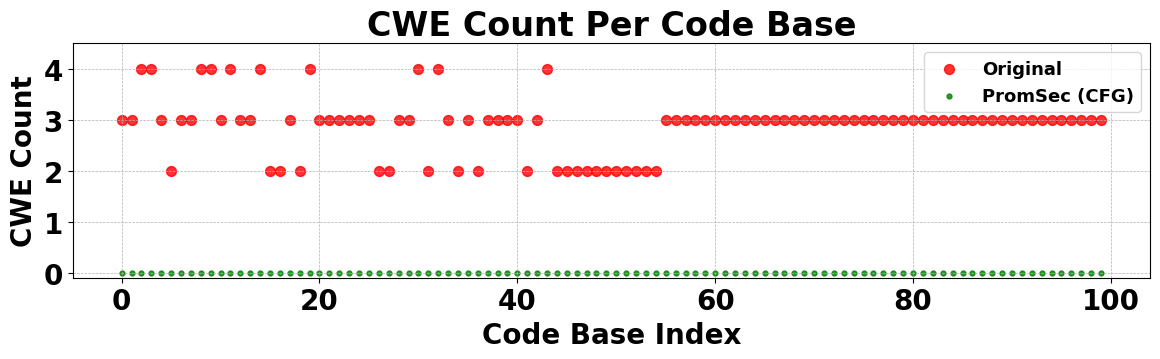

In [8]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np  # Don't forget to import numpy

plt.figure(figsize=(12, 4))
point_size = 50
alpha_value = 0.8  # Transparency: 1 is opaque, 0 is fully transparent

index = np.arange(100)

plt.scatter(index, k_org_arr, s=point_size,
            color='r', marker='o', label='Original', alpha=alpha_value)
plt.scatter(index, remaining_k_arr, s=point_size,
            color='g', marker='.', label='PromSec (CFG)', alpha=alpha_value)

plt.xlabel('Code Base Index')  # Capitalized 'Code Base Index'
plt.ylabel('CWE Count')  # Capitalized 'CWEs'
plt.title('CWE Count Per Code Base')  # Capitalized 'CWE Count Per Code Base'
plt.ylim(0, 4.5)
nth = 10  # Display every 5th label
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend(loc='best', fontsize=13)
plt.ylim(bottom=-0.1)  # Set the start of the y-axis to 0
# Setting y-axis to have integer ticks only
ax = plt.gca()  # get the current axis
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# plt.savefig("results_cfg_nov16/per_codebase_cfg.png", dpi=150)
# plt.savefig("results_cfg_nov16/per_codebase_cfg.pdf", dpi=150)


#### Plotting per-CWE hisogram  versus iteration

In [9]:
import itertools
from collections import Counter
org_cwe_freq= Counter(itertools.chain.from_iterable(CWE_org_arr))
prop_cwe_freq = Counter(itertools.chain.from_iterable(remaining_cwe_arr))

In [10]:
org_cwe_freq

Counter({259: 95, 89: 87, 78: 86, 327: 15, 20: 4, 703: 2})

In [11]:
prop_cwe_freq

Counter()

In [14]:
plt.rcParams['font.size'] = 15


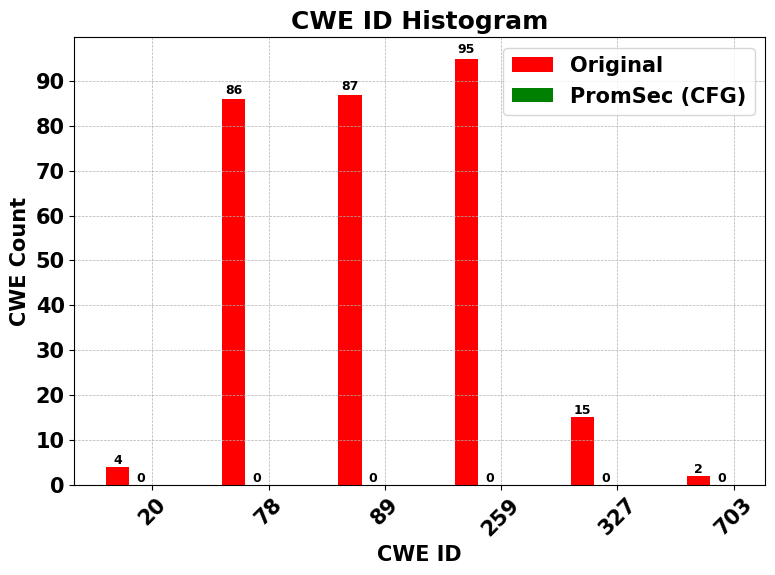

In [15]:
# Convert keys to integers:
org_cwe_freq   = {int(k): v for k, v in org_cwe_freq.items()}
prop_cwe_freq = {int(k): v for k, v in prop_cwe_freq.items()}

# Now you can merge and sort without type conflicts:
all_cwe_ids = sorted(set(org_cwe_freq.keys()) | set(prop_cwe_freq.keys()))

# 2. Plot grouped bar chart
bar_width = 0.2  # Adjusted for 4 bars
r1 = np.arange(len(all_cwe_ids))
r2 = [x + bar_width for x in r1]

fig, ax = plt.subplots(figsize=(8,6))

def annotate_bars(rects, ax):
    """
    Attach a text label above each bar displaying its height.
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.0051*height, 
                '%d' % int(height), 
                ha='center', va='bottom', fontsize=9)

# Create the bar plots and get the bar objects
bars1 = ax.bar(r1, [org_cwe_freq.get(cwe, 0) for cwe in all_cwe_ids], color='red', width=bar_width, label='Original')
bars2 = ax.bar(r2, [prop_cwe_freq.get(cwe, 0) for cwe in all_cwe_ids], color='green', width=bar_width, label='PromSec (CFG)')
# bars3 = ax.bar(r3, [worst_cwe_freq.get(cwe, 0) for cwe in all_cwe_ids], color='cyan', width=bar_width, label='Worst Fix')
# bars4 = ax.bar(r4, [final_cwe_freq.get(cwe, 0) for cwe in all_cwe_ids], color='gold', width=bar_width,  label='Final')

# Annotate each of the bars
annotate_bars(bars1, ax)
annotate_bars(bars2, ax)
# annotate_bars(bars3, ax)
# annotate_bars(bars4, ax)

# Title & Subtitle
plt.title('CWE ID Histogram', fontweight='bold')
plt.xlabel('CWE ID', fontweight='bold')
plt.ylabel('CWE Count', fontweight='bold')

# Set the x-ticks
plt.xticks([r + 1.5 * bar_width for r in range(len(all_cwe_ids))], all_cwe_ids, rotation=45)  # Added rotation for better visualization

# Ensure y-axis only has integer labels
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Create legend & Show graphic
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig("results_cfg_nov16/per_CWE_cfg.png", dpi=150)
plt.savefig("results_cfg_nov16/per_CWE_cfg.pdf", dpi=150)
plt.show()


### The no. iterations to cleanse CWEs

In [22]:
req_iter_num_arr = [x + 1 for x in req_iter_num_arr]

In [35]:
plt.rcParams['font.size'] = 13

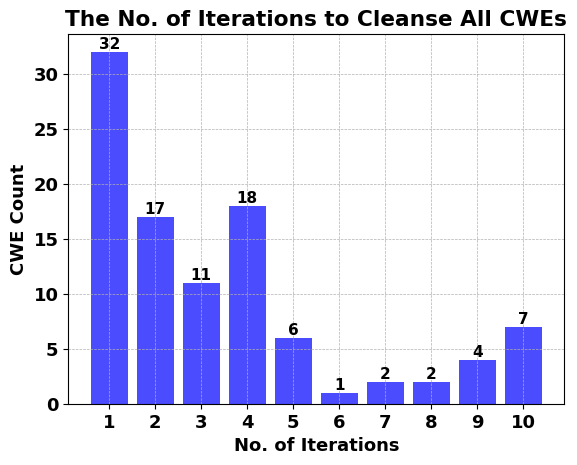

In [36]:
import matplotlib.pyplot as plt
# Create the histogram
hist, bins, patches = plt.hist(req_iter_num_arr, bins=np.arange(min(req_iter_num_arr), max(req_iter_num_arr) + 1.5) - 0.5, rwidth=0.8, color='blue', alpha=0.7)
# Annotate each bar with its value and set font size
for i in range(len(hist)):
    plt.text(bins[i] + 0.5, hist[i], str(int(hist[i])), ha='center', va='bottom', fontsize=11)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('No. of Iterations')  # Capitalized 'No. of Iterations', and 'Iterations' instead of 'iterations'
plt.ylabel('CWE Count')  # Capitalized 'Count'
plt.title('The No. of Iterations to Cleanse All CWEs')  # Capitalized 'The Number of Iterations to Cleanse CWEs'
plt.xticks(range(1, 11))
plt.savefig("results_cfg_nov16/hist_min_required_iterations_cfg.png", dpi=150)
plt.savefig("results_cfg_nov16/hist_min_required_iterations_cfg.pdf", dpi=150)

plt.show()


### The number of CWEs remaining after the 1st iteration

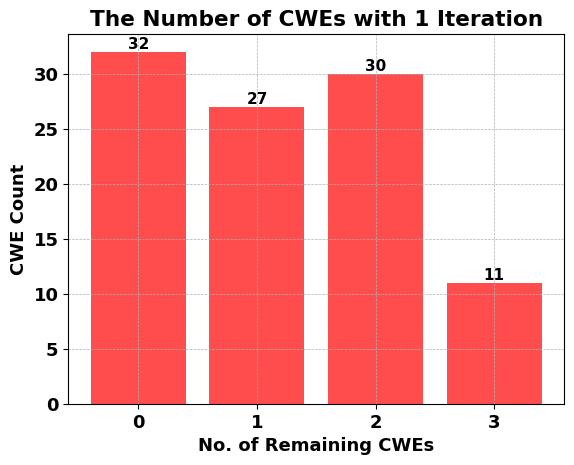

In [38]:
import matplotlib.pyplot as plt
# Create the histogram
hist, bins, patches = plt.hist(k_after_1_iter_arr, bins=np.arange(min(k_after_1_iter_arr), max(k_after_1_iter_arr) + 1.5) - 0.5, rwidth=0.8, color='red', alpha=0.7)
# Annotate each bar with its value and set font size
for i in range(len(hist)):
    plt.text(bins[i] + 0.5, hist[i], str(int(hist[i])), ha='center', va='bottom', fontsize=11)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('No. of Remaining CWEs')  # Capitalized 'No. of Remaining CWEs'
plt.ylabel('CWE Count')  # Capitalized 'Count'
plt.title('The Number of CWEs with 1 Iteration')  # Capitalized 'The Number of CWEs with 1 Iteration'
plt.xticks(range(4))

plt.savefig("results_cfg_nov16/hist_k_iter1_cfg.png", dpi=150)
plt.savefig("results_cfg_nov16/hist_k_iter1_cfg.pdf", dpi=150)
plt.show()
